# Quick Start - Sea Rise Risk

## Overview

This notebook helps us understand how Geospatial Analytics can hep determine the possible regions that come under the threat of rise in sea levels

Before starting, you have to install ibm pairs using `pip3 install -U ibmpairs`

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial Analytics API credentials in a file named `secrets.ini` in the below format:

```
[EIS]
api.host = https://api.ibm.com/geospatial/run/na/core/v3
api.key = <Your Geospatial Analytics API key>
api.tenant_id = <Your Geospatial Analytics Tenant ID>
api.org_id = <Your Geospatial Analytics Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [18]:
!pip install folium

In [19]:
%matplotlib inline
from datetime import datetime, timedelta
import os, re, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import query, client
import ibmpairs.authentication as authentication
import ibmpairs.catalog as catalog
import ibmpairs.client as client
import ibmpairs.query as query
import ibmpairs.dashboard as dashboard
import json
import rasterio
from PIL import Image

pd.set_option('display.max_colwidth', None)

iso8601 = "%Y-%m-%dT%H:%M:%SZ"

def get_extent(f):
    with open(f, "r") as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent

def display_raster(raster_file_name, colorMap, title = None, Max=None, Min=None, myextent=None,savepng=False):
    if  raster_file_name.endswith(".tiff"):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent=get_extent(raster_file_name+".json")
            data = raster_file.read(1)
            fig=plt.figure(figsize = (20, 12))
            if Max is None:
                Max=data.max()
            if Min is None:
                Min = data.min()
            plt.imshow(data, cmap = colorMap, vmin = Min, vmax = Max,extent = myextent)
            if not title:
                title=os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()
            if savepng:
                plt.axis('off')
                fig.savefig(raster_file_name.replace(".tiff",".jpg"), bbox_inches='tight', pad_inches=0)            

### Code Understanding

This code imports several libraries and defines some helper functions for working with raster files. The %matplotlib inline line ensures that any plots generated by Matplotlib will be displayed inline within the notebook. The iso8601 variable is a string containing the ISO 8601 date format, which is used throughout the code to parse dates and times.

The get_extent function takes a file name as input and returns the extent of the raster data as a list of coordinates. It uses the json library to read the JSON file associated with the raster file and extracts the minimum and maximum longitude and latitude values from the boundingBox field.

The display_raster function takes a raster file name, a color map, an optional title, maximum and minimum values, an optional extent, and a boolean indicating whether to save the plot as a PNG file. It opens the raster file using the rasterio library, calculates the maximum and minimum values if they are not provided, creates a figure, plots the raster data using the specified color map, sets the title, displays a color bar, displays the plot, and saves the plot as a PNG file if savepng is set to True.

In [20]:
import configparser
config = configparser.RawConfigParser()
config.read("../../auth/secrets.ini")

EIS_HOST       = config.get("EIS", "api.host")
EIS_API_KEY    = config.get("EIS", "api.key")
EIS_TENANT_ID  = config.get("EIS", "api.tenant_id") 
EIS_ORG_ID     = config.get("EIS", "api.org_id")  

p2_credentials  = client.get_client(api_key   = EIS_API_KEY,
                                    tenant_id = EIS_TENANT_ID,
                                    org_id    = EIS_ORG_ID,
                                    legacy    = False
                                   )

2024-06-17 10:14:54 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-17 10:14:54 - paw - INFO - Legacy Environment is False
2024-06-17 10:14:54 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-17 10:14:56 - paw - INFO - Authentication success.
2024-06-17 10:14:56 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


### Note
SRTM, JAXA, and GMTED are all digital elevation models (DEMs) that can be utilized for various applications. For this specific use case, we selected the SRTM DEM. Each DEM has different error margins and resolutions.

In [21]:
# Sea level rise and tepest risks using a GSA Filter predicate in the query : https://www.climate.gov/news-features/understanding-climate/climate-change-global-sea-level
# Every location between 0m and 10m  is at risks for the next 50 years (high tides, sealevel rise, & storms)  EPCCC said that  sea will rise by at least x meters up  to y meters depending of scenario by 2100 
query_name= "NY area at risk of sea rise level"
NY_Sea_rise_risk_queryJson = {
  "name" : query_name,
  "layers": [    
           { "type": "raster", 
              "id": "49506",  # SRTM DEM datalayer   30m resolution with error margin ...
              "temporal": {"intervals": [{"snapshot": "2024-01-01T00:00:00Z"}]}, "output": True,
              "filter": {"operator": "GT", "value": "0"}},   # Where elevation is higher than sea level (i.e. 0 ) 
          ],
  # the Area where fires happened
 "spatial": {"type": "square", "coordinates": [ 40.3725,-74.3498,  41.3396,-72.2332]},  # NY area
  # The dates 
 "temporal": {"intervals": [{"snapshot": "2024-01-01T00:00:00Z"}]}
}

This code defines a query called NY_Sea_rise_risk_queryJson that selects all pixels in the New York area that have elevations above sea level ("filter": {"operator": "GT", "value": "0"}). The query covers the entire time period from January 1, 2024 to January 1, 2024.

In [22]:
# Now, executes the query 
NY_Sea_rise_risk_query = query.submit_check_status_and_download(NY_Sea_rise_risk_queryJson)

2024-06-17 10:15:38 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-17 10:16:10 - paw - INFO - The query was successfully submitted with the id: 1718582400_17171047.
2024-06-17 10:16:20 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:16:51 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:17:22 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:17:53 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:18:25 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:18:56 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:19:27 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:19:58 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-17 10:20:29 - paw - INFO - The query 1718582400_17171047 has the status Running.
2024-06-1

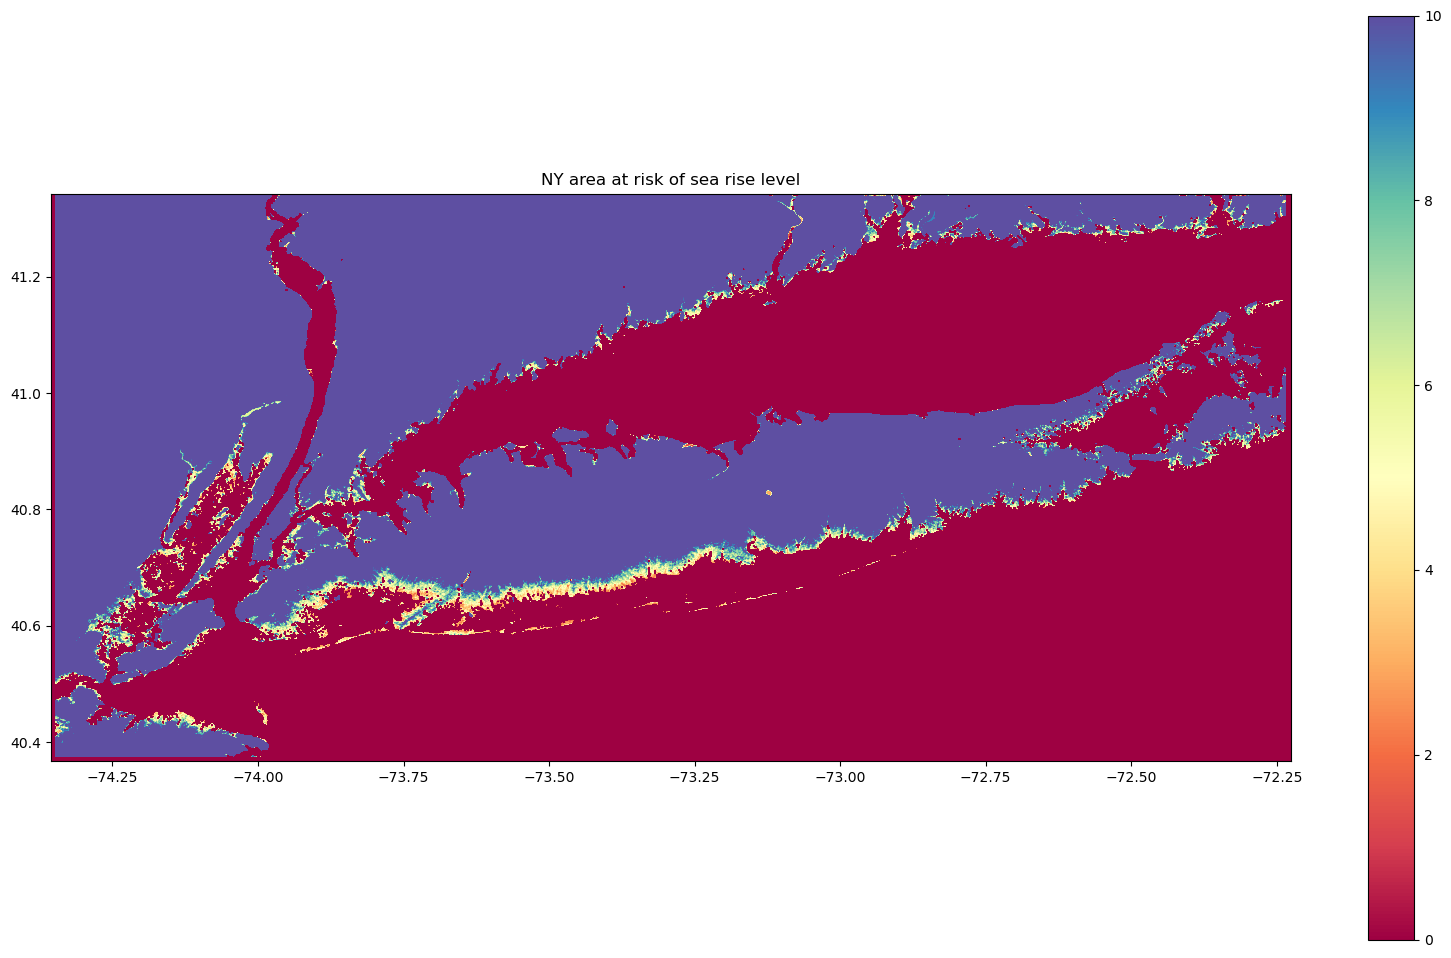

In [23]:
result_rasterfiles_list = NY_Sea_rise_risk_query.list_files()
for NY_risk_file in result_rasterfiles_list:
    display_raster(NY_risk_file, 'Spectral', title=query_name, Min=0, Max=10)


## Output

The output of this code is a list of raster files that represent the results of the query. Each file represents a single pixel in the selected area, and its value indicates the degree of risk associated with that pixel. Specifically, the values range from 0 to 10, with 0 indicating no risk and 10 indicating the highest level of risk.

The display_raster() function is used to visualize each raster file as an image, with the color scale set to Spectral (which maps low values to blue and high values to red). The title argument is used to add a title to each image, and the Min and Max arguments are used to set the minimum and maximum values for the color scale.


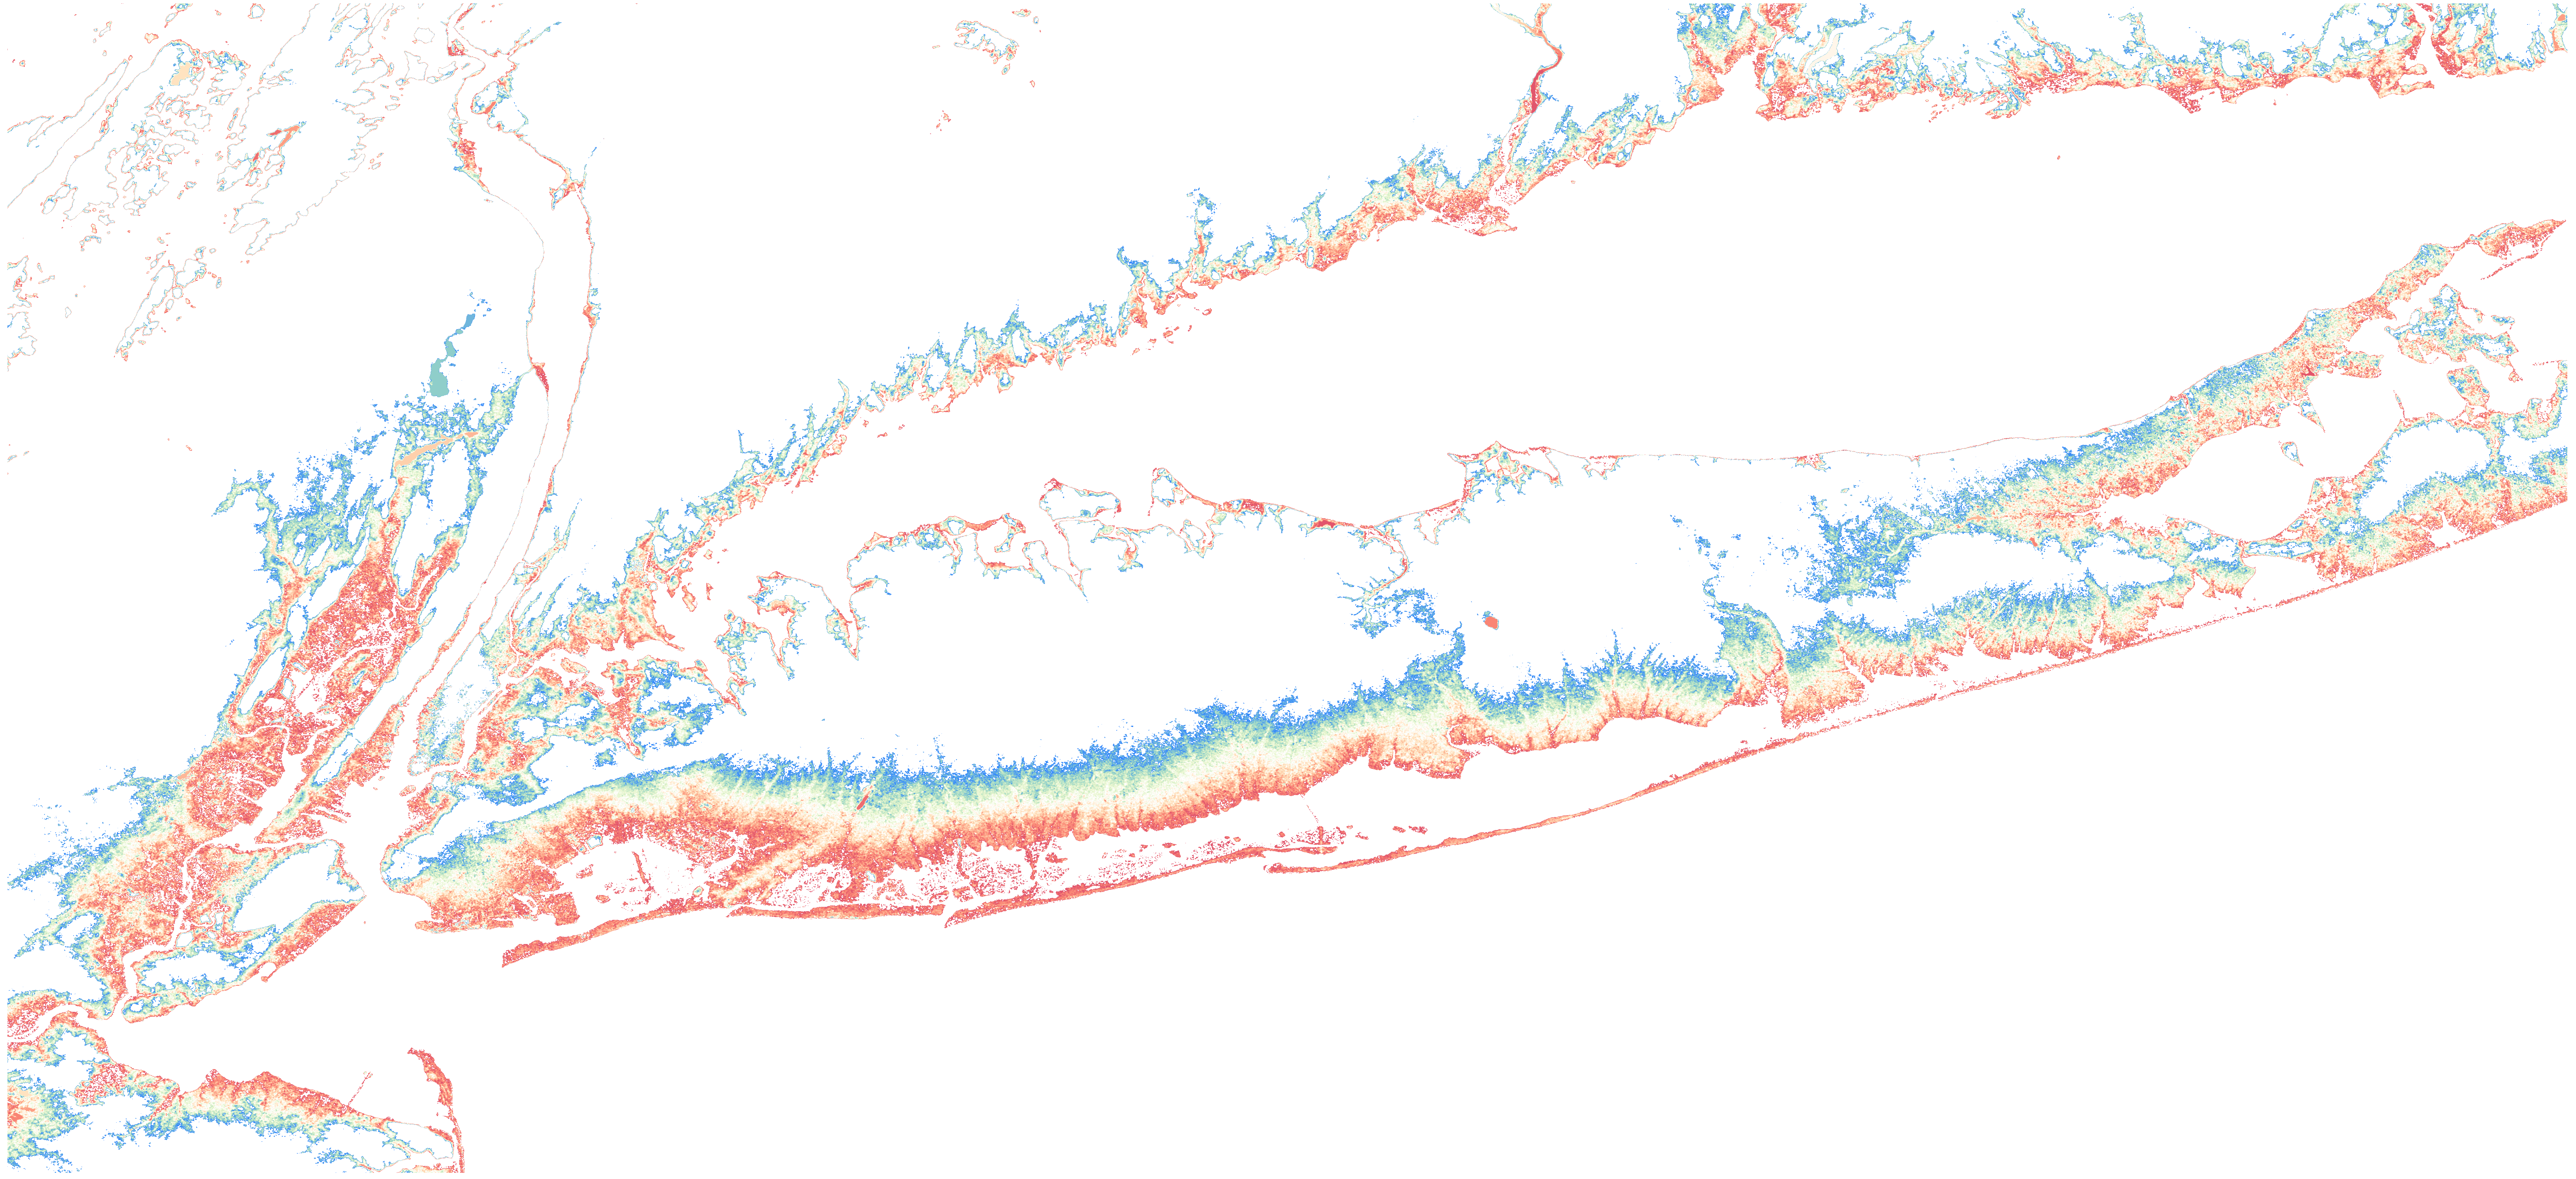

In [25]:
# For visualizing maps
import folium
import branca.colormap as cm
from matplotlib import colors as colors

Max_risk_elevation = 20

def create_fast_colormap_for_range(mycmmap_choice,vmin,vmax, empty_val):
    NYcm = mycmmap_choice.scale(vmin,vmax)   # cm.linear.Spectral_07.scale(0, 20)  # .to_step(1)
    NYcmArray = []
    for i in range(0,255, 1):
        if i> vmax or  i == empty_val:   # i>20 or i==0:
            NYcmArray.insert(i,(1, 0, 0, 0))
        else:
            NYcmArray.insert(i,colors.to_rgba(NYcm(i), 0.8))
    return NYcmArray

NYcmArray = create_fast_colormap_for_range(cm.linear.Spectral_07, 0,Max_risk_elevation, 0)

for NY_risk_file in result_rasterfiles_list:
    if NY_risk_file.endswith('.tiff'):
        with rasterio.open(NY_risk_file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds
            
            NYMap = folium.Map( max_bounds=True,
                    location=[(rb.bottom+rb.top)/2, (rb.left+rb.right)/2],   # [40.8768,-73.6195],
                    zoom_start=10,
                    min_lat=rb.bottom, # min_lat,
                    max_lat=rb.top,    # max_lat,
                    min_lon=rb.left,   # min_lon,
                    max_lon=rb.right   #max_lon
                    )
            
            folium.PolyLine([
                [rb.bottom, rb.left], [rb.top, rb.left],
                [rb.top, rb.right], [rb.bottom, rb.right],
                [rb.bottom, rb.left]
            ], color='black', weight=2.0, opacity=0.8).add_to(NYMap)
            NYdata = raster.read(1).astype(np.uint8)
            NYdata[NYdata >Max_risk_elevation] = 0   # set everything above 20 m  as  nodata and let be it 0
            NYcmArray = create_fast_colormap_for_range(cm.linear.Spectral_07, 0, Max_risk_elevation, 0)
            
            folium.raster_layers.ImageOverlay(
                        image=NYdata,opacity=0.7,
                        colormap=lambda value: NYcmArray[value],
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(NYMap)
            
            
            NYMap.add_child(cm.linear.Spectral_07)
NYMap

### Code Understanding

The code imports the necessary libraries (folium and branca) and defines a linear colormap (linear) with three colors (["green", "yellow", "red"]) and a minimum and maximum value (vmin=3 and vmax=10). It also defines the minimum and maximum longitude and latitude (min_lon, max_lon, min_lat, and max_lat) for the map.

The folium.Map() function creates the base map, with the max_bounds=True option ensuring that the map always covers the entire area of interest. The location argument sets the center of the map to New York City, while zoom_start sets the initial zoom level. The min_lat, max_lat, min_lon, and max_lon arguments set the boundaries of the map.

The for loop iterates over each file in the result_rasterfiles_list. If the file ends with .tiff, it prints the filename and opens it using rasterio. The raster.bounds attribute returns the boundaries of the raster image, which are used to add a boundary to the map using folium.PolyLine().

The rasterio.open() function reads the raster data into a NumPy array (data = raster_file.read(1)), and replaces any missing or invalid values with np.nan (data[data==-9999] = np.nan and data[data==0] = np.nan). The plt.savefig() function saves the raster data as a JPEG file

### Output

The output of this code is a Folium map that displays the results of the query. The map shows the boundaries of each raster file, along with the risk values mapped to colors using the Spectral color scheme. The risk values range from 0 to 20, with 0 indicating no risk and 10 indicating the highest level of risk.

The folium.Map() function creates the base map, while the folium.PolyLine() function adds a boundary to each raster file. The folium.raster_layers.ImageOverlay() function adds the raster image to the map, while the NYcm = cm.linear.Spectral_07.scale(0, 20) line sets up the color scale for the risk values. Finally, the NYMap object is displayed in a Jupyter Notebook cell.